# Processing IMERG Precipitation with Zarr backend

In [2]:
import fsspec
from dotenv import load_dotenv
import os
import xarray as xr
import io
import os
import zipfile
import fsspec
import geopandas as gpd
from azure.storage.blob import ContainerClient
import matplotlib.pyplot as plt

In [3]:
load_dotenv()

DEV_BLOB_SAS = os.getenv("DEV_BLOB_SAS")
DEV_BLOB_NAME = "imb0chd0dev"
IMERG_ZARR_ROOT = "az://global/imerg.zarr"
DEV_BLOB_URL = f"https://{DEV_BLOB_NAME}.blob.core.windows.net/"
DEV_BLOB_PROJ_URL = DEV_BLOB_URL + "projects" + "?" + DEV_BLOB_SAS
GLOBAL_CONTAINER_NAME = "global"
DEV_BLOB_GLB_URL = (DEV_BLOB_URL + GLOBAL_CONTAINER_NAME + "?" + DEV_BLOB_SAS)

dev_container_client = ContainerClient.from_container_url(DEV_BLOB_PROJ_URL)
dev_glb_container_client = ContainerClient.from_container_url(DEV_BLOB_GLB_URL)

def _load_blob_data(blob_name):
    container_client = dev_container_client
    blob_client = container_client.get_blob_client(blob_name)
    data = blob_client.download_blob().readall()
    return data

def _load_gdf_from_blob(blob_name, shapefile: str = None):
    blob_data = _load_blob_data(blob_name)
    with zipfile.ZipFile(io.BytesIO(blob_data), "r") as zip_ref:
        zip_ref.extractall("temp")
        if shapefile is None:
            shapefile = [f for f in zip_ref.namelist() if f.endswith(".shp")][
                0
            ]
        gdf = gpd.read_file(f"temp/{shapefile}")
    return gdf

We can start by loading in the full IMERG store that is hosted on Azure. This contains daily precipitation data between 2000-2005 (2033 observations). 

Importantly, this will lazy-load the full object so that the whole thing doesn’t need to be stored in memory. See the API reference here. `xarray` will also automatically store arrays as Dask arrays, if Dask is installed.

`xarray` will also make use of Zarr's consolidated metadata, stored in a `.zmetadata` file, to more efficently open the store. See [these docs](https://docs.xarray.dev/en/latest/user-guide/io.html#io-zarr-consolidated-metadata) for more details.

This takes about **3-4mins**, which is longer than expected given that the `xr.open_zarr()` call should only be reading in basic metadata. This might be because: 

- The store has too many chunks, which might be adding too much overhead. However, I rechunked this dataset down to a total of 160 chunks and did not find this to significantly change the read time.
- Some GitHub issues ([for example](https://github.com/pydata/xarray/issues/6036)) suggest that Dask could be causing issues. However, using `xr.open_dataset(chunks=None)` to bypass Dask did not have any impact. 
- Slow network speeds (to test)
- Issues with `adlfs` mappers - see GitHub issue [here](https://github.com/fsspec/adlfs/issues/161) (to test) 

In [4]:
# 3-5mins
fs = fsspec.filesystem("az", account_name=DEV_BLOB_NAME, sas_token=DEV_BLOB_SAS)
fs = fs.get_mapper(IMERG_ZARR_ROOT)
ds = xr.open_zarr(fs)
print(f"Dataset is {ds.nbytes/1000000000} GB")

Dataset is 52.695397864 GB


The resulting `Dataset` has lat/lon/time dimensions, with precipitation values stored as `float32`s. We can also see that this dataset is split into chunks that are 225 x 900 x 1 (lat x lon x time) in dimension, which is just under 800KB in size. This is much smaller than recommended by the [Dask documentation](https://docs.dask.org/en/stable/array-best-practices.html#select-a-good-chunk-size), which suggests chunks to not be smaller than 100MB. 

In [5]:
ds

<xarray.Dataset> Size: 53GB
Dimensions:           (lat: 1800, lon: 3600, time: 2033)
Coordinates:
  * lat               (lat) float32 7kB -89.95 -89.85 -89.75 ... 89.85 89.95
  * lon               (lon) float32 14kB -179.9 -179.8 -179.8 ... 179.9 179.9
  * time              (time) datetime64[ns] 16kB 2000-06-01 ... 2005-12-22
Data variables:
    precipitationCal  (lat, lon, time) float32 53GB dask.array<chunksize=(225, 900, 1), meta=np.ndarray>

Imagining that we're working in Haiti, we can now clip this dataset to the Haiti country bounds and calculate some basic raster stats. Once clipped to the bounding box of Haiti, the data we need to store in memory is reduced to ~4MB. We can hold this in memory by calling the `compute()` method, which takes **~40s**. 

In [6]:
# 40s-1min
gdf = _load_gdf_from_blob(
    "ds-aa-hti-hurricanes/raw/codab/hti.shp.zip",
    shapefile="hti_adm0.shp"
)

minx, miny, maxx, maxy = gdf.total_bounds
ds_box = ds.sel(lon=slice(minx, maxx), lat=slice(miny, maxy))
ds_box.compute()
print(f"Dataset is {ds_box.nbytes/1000000000} GB")

Dataset is 0.004968852 GB


In [7]:
ds_box

<xarray.Dataset> Size: 5MB
Dimensions:           (lat: 21, lon: 29, time: 2033)
Coordinates:
  * lat               (lat) float32 84B 18.05 18.15 18.25 ... 19.85 19.95 20.05
  * lon               (lon) float32 116B -74.45 -74.35 -74.25 ... -71.75 -71.65
  * time              (time) datetime64[ns] 16kB 2000-06-01 ... 2005-12-22
Data variables:
    precipitationCal  (lat, lon, time) float32 5MB dask.array<chunksize=(21, 29, 1), meta=np.ndarray>

Calculating the mean precipitation across the time dimension is now <1s, which we can further clip and plot very easily.

In [8]:
da_mean = ds_box["precipitationCal"].mean(dim="time")

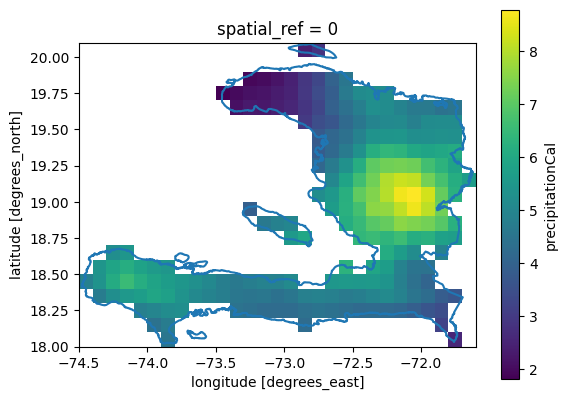

In [9]:
da_box = da_mean.rio.write_crs(4326)
da_box = da_box.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
da_clip = da_box.rio.clip(gdf.geometry)

fig, ax = plt.subplots()
gdf.boundary.plot(ax=ax)
da_clip.plot(ax=ax)

In [11]:
ds_clip = ds_box.rio.write_crs(4326)
ds_clip = ds_clip.rio.set_spatial_dims(x_dim="lon", y_dim="lat")
ds_clip = ds_clip.rio.clip(gdf.geometry)

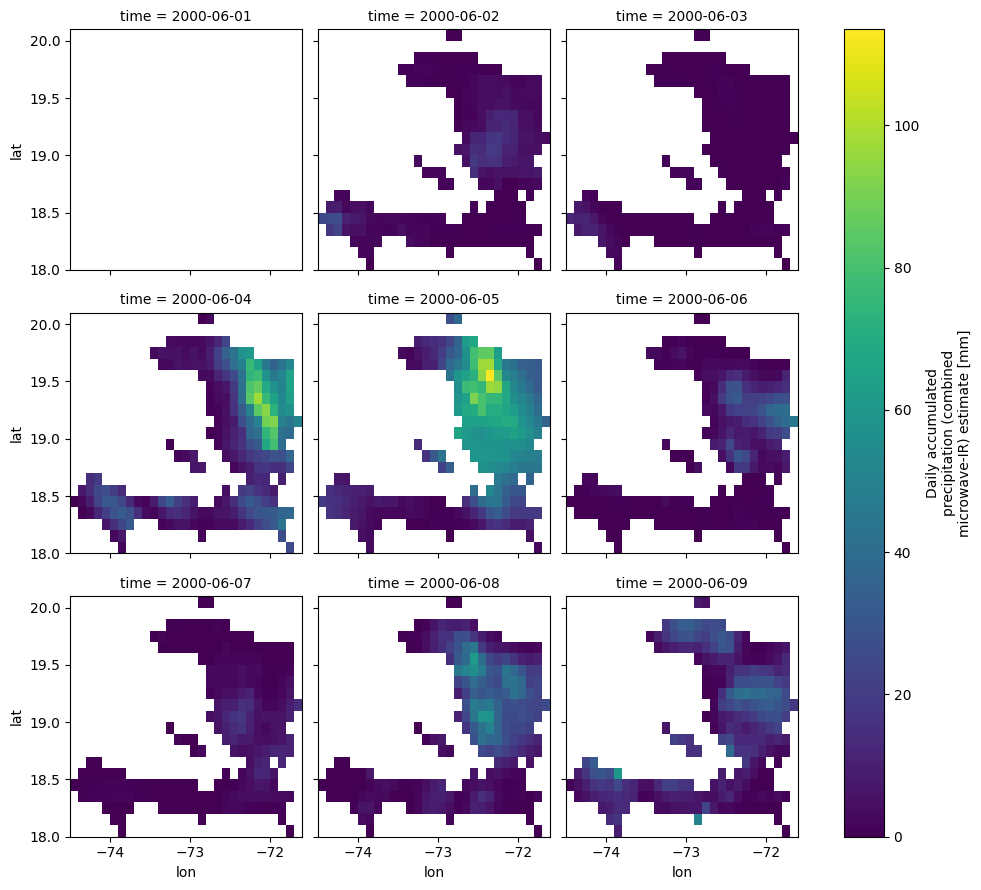

In [18]:
ds_clip.precipitationCal.isel({"time": slice(0,9)}).plot(x="lon", y="lat", col="time", col_wrap=3)

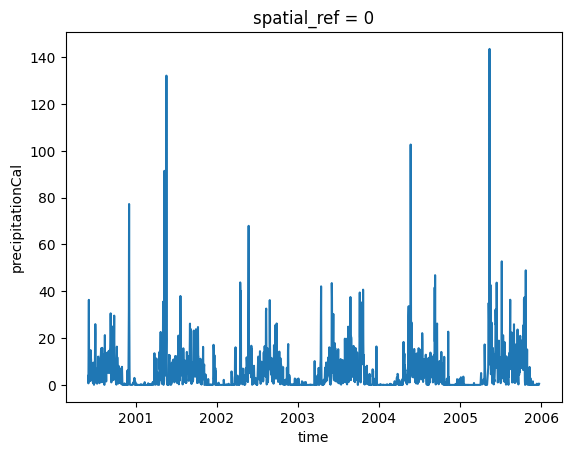

In [19]:
# 2mins
ds_clip.precipitationCal.mean(dim=["lon", "lat"]).plot()